In [1]:
#create csv file for test
import os
import csv
img_dir="./isic-2020-resized/test-resized"
with open('test-name.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ["name"]
    writer.writerow(field)
    for x in os.listdir(img_dir):
        writer.writerow([x])

In [2]:
#Imports
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.models import resnet50

0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


C:\Users\chamk\AppData\Local\Temp\ipykernel_28804\4224001498.py:65: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)
  plt.imshow(sample[0].T)
C:\Users\chamk\AppData\Local\Temp\ipykernel_28804\4224001498.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


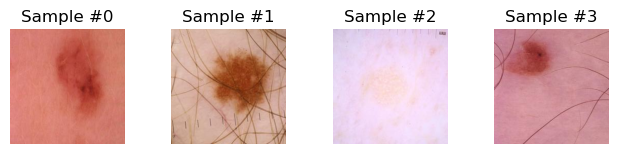

0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


C:\Users\chamk\AppData\Local\Temp\ipykernel_28804\4224001498.py:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


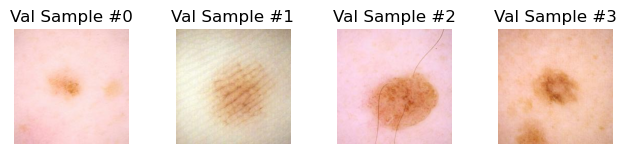

0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


C:\Users\chamk\AppData\Local\Temp\ipykernel_28804\4224001498.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


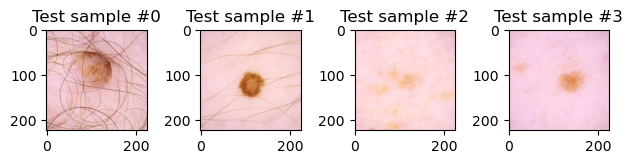

In [3]:
#Chargement des données
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+".jpg")
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
class CustomImageTestset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_name = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_name.iloc[idx,0])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image
    
train_dataset=CustomImageDataset(annotations_file='./isic-2020-resized/train-labels.csv',img_dir='./isic-2020-resized/train-resized')

# Assuming train_dataset contains all your data
total_size = len(train_dataset)

# Calculate the size of the validation set (1/5 of the total size)
val_size = total_size // 5

# Calculate the size of the training set
train_size = total_size - val_size

# Use random_split to create datasets for training and validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_dataset=CustomImageTestset(annotations_file='./test-name.csv',img_dir='./isic-2020-resized/test-resized')

for i, sample in enumerate(train_dataset):
    print(i, sample[0].shape, sample[1])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0].T)
    if i == 3:
        plt.show()
        break
        
for i, sample in enumerate(val_dataset):
    print(i, sample[0].shape, sample[1])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Val Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0].T)
    if i == 3:
        plt.show()
        break
        
for i, sample in enumerate(test_dataset):
    print(i, sample.shape)
    ay = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ay.set_title('Test sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample.T)
    if i == 3:
        plt.show()
        break

In [4]:
#Mise en forme des données
batch_size = 64

# for batch, (X, y) in enumerate(train_dataloader):
#     print(f"Shape of X [N, C, H, W]: {X.shape}")
#     #print(f"Shape of y: {y.shape} {y.dtype}")
#     print(f"batch:{batch_size}")
#     break

In [5]:
# Charger les données 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=3)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=3)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True,num_workers=3)

In [6]:
# for X in test_dataloader:
#     print(f"Shape of X [N, C, H, W]: {X.shape}")
#     #print(f"Shape of y: {y.shape} {y.dtype}")
#     break

In [7]:
# Création du modèle
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Modèle pré_entraîné  
model = resnet50(pretrained = True)

# on gèle les couches(pour éviter leur rétropropagation )
for param in model.parameters() : 
    param.requires_grad = False

# Modification de la dernière couche 
# number_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(device)


Using cuda device


c:\Users\chamk\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chamk\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\chamk/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:10<00:00, 9.39MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
#défini la fonction de perte et l'optimiseur
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer Adam and not SGD

In [9]:
#training
epochs=5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    size = len(train_dataset)
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.float().to(device), y.to(device)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            # Validation
            
            val_loss = 0.0
            correct_predictions = 0
            total_samples = 0
            total_samples_0 = 0
            total_samples_1 = 0
            correct_predictions_0 = 0
            correct_predictions_1 = 0

            with torch.no_grad():
                model.eval()  # Set the model to evaluation mode
                for val_batch, (val_X, val_y) in enumerate(val_dataloader):
                    val_X, val_y = val_X.float().to(device), val_y.to(device)

                    val_pred = model(val_X)
                    val_loss += loss_fn(val_pred, val_y).item()

                    _, predicted_labels = torch.max(val_pred, 1)
                    correct_predictions_0 += ((val_y == 0) & (predicted_labels == 0)).sum().item()
                    correct_predictions_1 += ((val_y == 1) & (predicted_labels == 1)).sum().item()
                    
                    # Calculate accuracy for each class
                    total_samples_0 += (val_y == 0).sum().item()
                    total_samples_1 += (val_y == 1).sum().item()

            accuracy_0 = correct_predictions_0 / total_samples_0
            accuracy_1 = correct_predictions_1 / total_samples_1

            avg_val_loss = val_loss / (val_batch + 1)
            print(f"Validation loss: {avg_val_loss:.4f}")
            # Display class-wise accuracy
            print(f"        Accuracy for class 0: {accuracy_0:.4f}    class 1: {accuracy_1:.4f}")
            print()
print("Done!")
    



Epoch 1
-------------------------------
